<a href="https://colab.research.google.com/github/larissavvsous/Mineracao-de-Dados/blob/main/Aula_DM_Mineracao_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

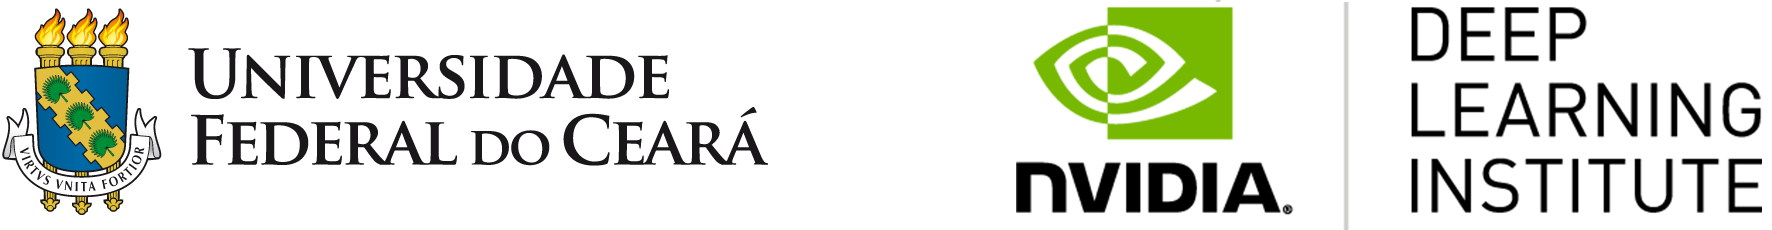

# Mineração de Textos

Neste tutorial, faremos um desvio de dados independentes, como imagens estáticas, para dados que dependem de outros itens de dados em uma sequência. Para nosso exemplo, usaremos frases de texto. A linguagem é naturalmente composta de dados sequenciais, na forma de caracteres em palavras e palavras em frases. Outros exemplos de dados sequenciais incluem preços de ações e dados meteorológicos ao longo do tempo. Os vídeos, embora contenham imagens estáticas, também são sequências. Os elementos dos dados têm uma relação com o que vem antes e com o que vem depois, e esse fato requer uma abordagem diferente.

## Objetivos

* Prepare a sequencia de dados usando uma [recurrent neural network](https://developers.google.com/machine-learning/glossary#recurrent-neural-network) (RNN)
* Construir e treinar um modelo para realizar previsão de palavras

## Gerador de Títulos (Headline Generator)

Todos nós já vimos preditores de texto em aplicativos como barras de pesquisa, em telefones celulares ou em editores de texto que fornecem preenchimento automático de frases. Muitos dos bons modelos de previsão de texto são treinados em conjuntos de dados muito grandes e levam muito tempo e/ou capacidade de processamento para serem treinados. Para este exercício, nosso preditor será bastante simples, mas fornecerá alguma exposição simples ao processamento de linguagem, dados de sequência e um dos elementos clássicos da arquitetura usados para treinar sequências, *recurrent neural networks* or *RNNs*.

## Lendo os Dados

Nosso conjunto de dados consiste em manchetes do jornal [New York Times](https://www.nytimes.com/) ao longo de vários meses. Começaremos lendo todas as manchetes dos artigos. Os artigos estão em arquivos CSV, então podemos usar  *pandas* para lê-los.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

nyt_dir = "/content/drive/MyDrive/data-mineracao/articles-20240125T114502Z-001/articles/"

dirs = os.listdir(nyt_dir)

all_headlines = []
for filename in os.listdir(nyt_dir):
    if 'Articles' in filename:
        # Read in all the data from the CSV file
        headlines_df = pd.read_csv(nyt_dir + filename)
        # Add all of the headlines to our list
        all_headlines.extend(list(headlines_df.headline.values))
len(all_headlines)

9335

Vamos dar uma olhada em nossas primeiras manchetes:

In [ ]:
all_headlines[:20]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College']

## Curagem dos dados - Limpeza dos dados

Uma parte importante das tarefas de processamento de linguagem natural (PLN) (onde os computadores lidam com a linguagem) é processar o texto de uma forma que os computadores possam entendê-lo. Pegaremos cada uma das palavras que aparecem em nosso conjunto de dados e representaremos com um número. Isso fará parte de um processo chamado *tokenization*.

Antes de fazermos isso, precisamos ter certeza de que temos bons dados. Deve-se ver se existem manchetes listadas como "Desconhecida". Não queremos esses itens em nosso conjunto de treinamento, então iremos filtrá-los:

In [ ]:
# Remove todos os headlines com valor "Unknown"
all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

8603

Vamos dar outra olhada:

In [ ]:
all_headlines[:20]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College']

Também queremos remover a pontuação e deixar nossas frases todas em letras minúsculas, porque isso tornará nosso modelo mais fácil de treinar. Para nossos propósitos, há pouca ou nenhuma diferença entre uma linha que termina com "!" ou "?" ou se as palavras estão em maiúscula, como em "O" ou em minúsculas, como em "o". Com menos tokens exclusivos, nosso modelo será mais fácil de treinar.

Poderíamos filtrar nossas frases antes da tokenização, mas não precisamos fazer isso porque tudo isso pode ser feito usando o Keras `Tokenizer`.

## Tokenization

No momento, nosso conjunto de dados consiste em um conjunto de títulos, cada um composto por uma série de palavras. Queremos dar ao nosso modelo uma forma de representar essas palavras de uma forma que ele possa compreender. Com a tokenização, separamos um trecho de texto em pedaços menores (tokens), que neste caso são palavras. Cada palavra exclusiva recebe um número, pois é uma forma de nosso modelo entender os dados. Keras tem uma classe que nos ajudará a tokenizar nossos dados:

```python
tf.keras.preprocessing.text.Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
)
```


Dando uma olhada na classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) no Keras, vemos que os valores padrão já estão configurados para nosso caso de uso . A string `filters` já remove a pontuação e o sinalizador `lower` define as palavras para minúsculas

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the words in our headlines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_headlines)
total_words = len(tokenizer.word_index) + 1
print('Total de Palavras: ', total_words)

Total de Palavras:  11753


Podemos dar uma olhada rápida no dicionário `word_index` para ver como o tokenizer salva as palavras:

In [ ]:
# Print a subset of the word_index dictionary created by Tokenizer
subset_dict = {key: value for key, value in tokenizer.word_index.items() \
               if key in ['a','man','a','plan','a','canal','panama']}
print(subset_dict)

{'a': 2, 'plan': 82, 'man': 138, 'panama': 3379, 'canal': 6138}


Podemos usar o método `texts_to_sequences` para ver como o tokenizer salva as palavras:

In [ ]:
tokenizer.texts_to_sequences(['a','man','a','plan','a','canal','panama'])

[[2], [138], [2], [82], [2], [6138], [3379]]

## Criando sequências

Agora que tokenizamos os dados, transformamos cada palavra em um número representativo, criaremos sequências de tokens a partir dos títulos. É nessas sequências que treinaremos nosso modelo de aprendizado profundo.

Por exemplo, vejamos o título “nvidia launches ray tracing gpus”. Cada palavra será substituída por um número correspondente, por exemplo: nvidia - 5, launches - 22, ray - 94, tracing - 16, gpus - 102. A sequência completa seria: [5, 22, 94, 16, 102]. No entanto, também é valioso treinar nas sequências menores do título, como “nvidia launches”. Pegaremos cada título e criaremos um conjunto de sequências para preencher nosso conjunto de dados. A seguir, vamos usar nosso tokenizer para converter nossos títulos em um conjunto de sequências.

In [ ]:
# Converte os dados para uma sequencia de tokens
input_sequences = []
for line in all_headlines:
    # Converte o headline em uma sequencia de tokens
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Cria uma série de sequencias para cada headline
    for i in range(1, len(token_list)):
        partial_sequence = token_list[:i+1]
        input_sequences.append(partial_sequence)

print(tokenizer.sequences_to_texts(input_sequences[:5]))
input_sequences[:5]

['finding an', 'finding an expansive', 'finding an expansive view', 'finding an expansive view of', 'finding an expansive view of a']


[[403, 17],
 [403, 17, 5242],
 [403, 17, 5242, 543],
 [403, 17, 5242, 543, 4],
 [403, 17, 5242, 543, 4, 2]]

## Sequências de preenchimento

No momento, nossas sequências têm comprimentos variados. Para que nosso modelo seja capaz de treinar com os dados, precisamos fazer com que todas as sequências tenham o mesmo comprimento. Para fazer isso, adicionaremos preenchimento às sequências. Keras tem um método [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) que podemos usar.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determina o coprimento máximo da sequencia
max_sequence_len = max([len(x) for x in input_sequences])

# Preencha todas as sequências com zeros no início para torná-las todas com comprimento máximo
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       403,  17], dtype=int32)

## Criação de preditores e alvo

Também queremos dividir nossas sequências em preditores e um alvo. A última palavra da sequência será nosso alvo e as primeiras palavras da sequência serão nossos preditores. Por exemplo, dê uma olhada no título completo: "nvidia releases ampere graphics cards"

<table>
<tr><td>PREDICTORS </td> <td>           TARGET </td></tr>
<tr><td>nvidia                   </td> <td>  releases </td></tr>
<tr><td>nvidia releases               </td> <td>  ampere </td></tr>
<tr><td>nvidia releases ampere      </td> <td>  graphics</td></tr>
<tr><td>nvidia releases ampere graphics </td> <td>  cards</td></tr>
</table>

In [ ]:
# Predictors are every word except the last
predictors = input_sequences[:,:-1]
# Labels are the last word
labels = input_sequences[:,-1]
labels[:5]

array([  17, 5242,  543,    4,    2], dtype=int32)

Estes objectivos são categóricos. Estamos prevendo uma palavra do nosso vocabulário total possível. Em vez de a rede prever números escalares, faremos com que ela preveja categorias binárias.

In [ ]:
from tensorflow.keras import utils

labels = utils.to_categorical(labels, num_classes=total_words)

## Criando o Modelo

Para definição do nosso modelo, usaremos algumas **novas camadas** para lidar com nossos dados sequenciais.

### [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Nossa primeira camada é um *embedding layer*:

```Python
model.add(Embedding(input_dimension, output_dimension, input_length=input_len))
```

Esta camada pegará as sequências tokenizadas e aprenderá uma incorporação para todas as palavras no conjunto de dados de treinamento. Matematicamente, os `embeddings` funcionam da mesma maneira que um neurônio em uma rede neural, mas conceitualmente, seu objetivo é reduzir o número de dimensões para alguns ou todos os recursos. Neste caso, representará cada palavra como um vetor, e as informações dentro desse vetor conterão as relações entre cada palavra.

Learn more about embedding layers [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).

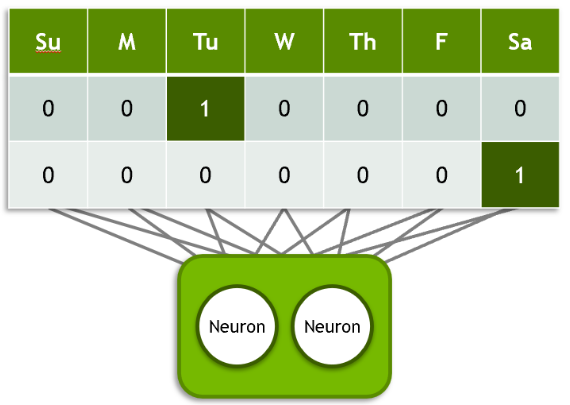

### [Long Short Term Memory Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

Nossa próxima e muito importante camada é uma camada de memória de longo e curto prazo (*long short term memory layer* - LSTM). Um LSTM é um tipo de rede neural recorrente ou RNN. Ao contrário das redes feed-forward tradicionais que vimos até agora, as redes recorrentes possuem loops, permitindo que a informação persista. Aqui está uma representação de uma rede recorrente:

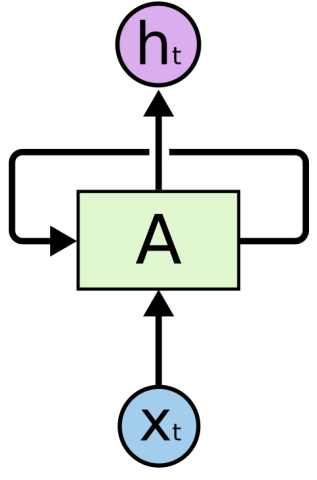

Novas informações (x) são passadas para a rede, que emite uma previsão (h). Além disso, as informações dessa camada são salvas e usadas como entrada para a próxima previsão. Isso pode parecer um pouco complicado, mas vamos dar uma olhada no desenrolar:

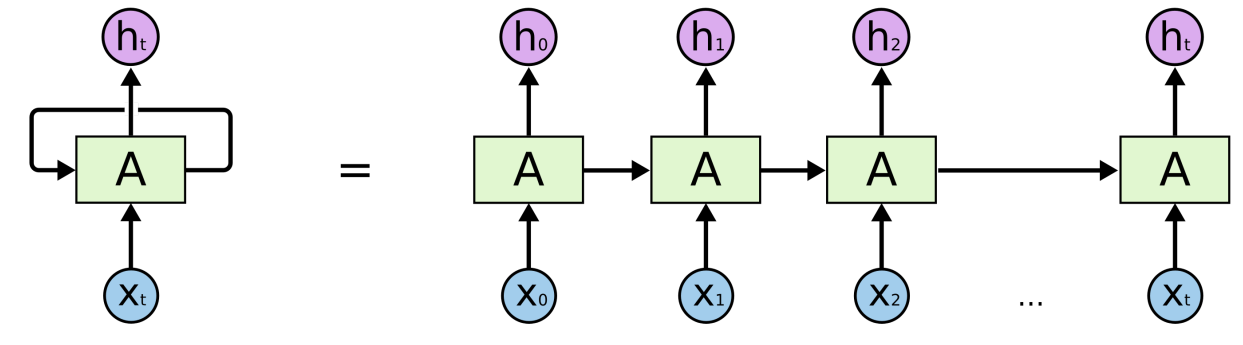

Podemos ver que quando um novo dado (x) é alimentado na rede, essa rede emite uma previsão (h) e também passa algumas informações para a próxima camada. A próxima camada obtém outro dado, mas também aprende com a camada anterior.

As RNNs tradicionais sofrem com o problema de informações mais recentes contribuírem mais do que informações anteriores. LSTMs são um tipo especial de camada recorrente capaz de aprender e reter informações de longo prazo. Se quiser ler mais sobre RNNs e LSTMs, recomendamos [este artigo](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Vamos então criar nosso modelo:

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Input is max sequence length - 1, as we've removed the last word for the label
input_len = max_sequence_len - 1

model = Sequential()

# Add input embedding layer
model.add(Embedding(total_words, 10, input_length=input_len))

# Add LSTM layer with 100 units
model.add(LSTM(100))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 10)            117530    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 11753)             1187053   
                                                                 
Total params: 1348983 (5.15 MB)
Trainable params: 1348983 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compilar o Modelo

Compilamos nosso modelo com entropia cruzada (cross entropy) categórica, pois prevemos categoricamente uma palavra de nosso vocabulário total. Nesse caso, não vamos usar a acurácia como métrica, porque a predição do texto não é medida como sendo mais ou menos precisa da mesma forma que a classificação de imagens.

Também selecionaremos um otimizador específico que seja adequado para tarefas LSTM, chamado otimizador **Adam**. É importante saber que diferentes otimizadores podem ser melhores para diferentes tarefas de aprendizado profundo.

Você pode ler mais sobre eles, incluindo o otimizador Adam [aqui](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

Verifique o que acontece com uso de Adagrad e RMSProp.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Treinamento do Modelo

O treinamento desta vez será executado por 30 épocas, o que levará alguns minutos. Você notará que não temos uma pontuação de precisão de treinamento ou validação neste caso. **Isso reflete nosso problema diferente de previsão de texto.**

In [ ]:
model.fit(predictors, labels, epochs=30, verbose=1)

Epoch 1/30
1666/1666 [==============================] - 25s 13ms/step - loss: 7.8920
Epoch 2/30
1666/1666 [==============================] - 11s 6ms/step - loss: 7.4714
Epoch 3/30
1666/1666 [==============================] - 9s 5ms/step - loss: 7.2652
Epoch 4/30
1666/1666 [==============================] - 10s 6ms/step - loss: 7.0467
Epoch 5/30
1666/1666 [==============================] - 10s 6ms/step - loss: 6.8089
Epoch 6/30
1666/1666 [==============================] - 10s 6ms/step - loss: 6.5548
Epoch 7/30
1666/1666 [==============================] - 9s 5ms/step - loss: 6.3020
Epoch 8/30
1666/1666 [==============================] - 10s 6ms/step - loss: 6.0503
Epoch 9/30
1666/1666 [==============================] - 10s 6ms/step - loss: 5.8159
Epoch 10/30
1666/1666 [==============================] - 10s 6ms/step - loss: 5.5896
Epoch 11/30
1666/1666 [==============================] - 9s 5ms/step - loss: 5.3710
Epoch 12/30
1666/1666 [==============================] - 10s 6ms/step - loss

## Discussão dos Resultados

Podemos ver uma perda ao longo do treinamento. Poderíamos treinar ainda mais nosso modelo para diminuir a perda, mas isso levaria algum tempo e não estamos procurando um preditor de texto perfeito no momento. A seguir, vamos tentar usar o modelo para fazer previsões.

## Fazendo Predições

Para fazer previsões, precisaremos começar com um texto inicial e prepará-lo da mesma forma que preparamos nosso conjunto de dados. Isso significará tokenização e preenchimento. Depois de fazer isso, podemos passá-lo para nosso modelo para fazer uma previsão. Criaremos uma função para fazer isso chamada `predict_next_token`:

In [ ]:
import numpy as np

def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction_probabilities = model.predict(token_list, verbose=0)
    predicted_class_index = np.argmax(prediction_probabilities)
    return predicted_class_index

In [ ]:
prediction = predict_next_token("today in new york")
prediction

73

Vamos usar nosso tokenizer para decodificar a palavra prevista:

In [ ]:
generated_text = tokenizer.sequences_to_texts([[prediction]])
print(generated_text)

['today']


## Generar Novos Headlines

Agora que podemos prever novas palavras, vamos criar uma função que possa prever títulos de mais de uma palavra. A função abaixo cria um novo título de comprimento arbitrário.

In [ ]:
def generate_headline(seed_text, next_words=1):
    for _ in range(next_words):
        # Predict next token
        prediction = predict_next_token(seed_text)
        # Convert token to word
        next_word = tokenizer.sequences_to_texts([prediction])[0]
        # Add next word to the headline. This headline will be used in the next pass of the loop.
        seed_text += " " + next_word
    # Return headline as title-case
    return seed_text.title()

Agora experimente algumas manchetes!

In [ ]:
import numpy as np

def generate_headline(seed_text, next_words=5):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        prediction_probabilities = model.predict(token_list, verbose=0)
        predicted_class_index = np.argmax(prediction_probabilities)
        predicted_word = tokenizer.index_word.get(predicted_class_index, "")
        seed_text += " " + predicted_word

    return seed_text

# Exemplo de uso
seed_texts = ['today in new york', 'weather forecast for tomorrow', 'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

today in new york today a new york times
weather forecast for tomorrow at the u s a
crime has become a informant’s case of ‘my


Os resultados podem ser um pouco desanimadores após 30 épocas de treinamento. Podemos notar que a maioria das manchetes faz algum sentido gramatical, mas não indica necessariamente uma boa compreensão contextual. Os resultados podem melhorar um pouco executando mais épocas. Você pode fazer isso executando a célula `fit` de treinamento novamente (e novamente!) para treinar mais 30 épocas de cada vez. Você deverá ver o valor da perda diminuir. Em seguida, tente os testes novamente. Os resultados podem variar um pouco!

Outras melhorias seriam tentar usar embeddings pré-treinados com Word2Vec ou GloVe, em vez de aprendê-los durante o treinamento, como fizemos com a camada Keras Embedding. Algumas informações sobre como fazer isso podem ser encontradas [aqui](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

Em última análise, porém, a PNL foi além dos modelos LSTM simples para modelos pré-treinados baseados em Transformer, que são capazes de aprender o contexto da linguagem a partir de grandes quantidades de dados textuais, como a Wikipedia. Esses modelos pré-treinados são então usados como ponto de partida para a aprendizagem por transferência para resolver tarefas de PNL, como a que acabamos de tentar para a conclusão do texto. Você pode experimentar um desses modelos verificando este [preditor de texto de última geração aqui](https://transformer.huggingface.co/doc/gpt2-large) baseado em um modelo [GPT-2](https://openai.com/blog/better-language-models/).

Para saber mais sobre modelos baseados em Transformer, confira [este blog](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) sobre Representações de codificadores bidirecionais de transformadores (BERT).

## Resumo

**Ótimo trabalho!**

Você treinou com sucesso um modelo para prever palavras em um título e usou esse modelo para criar títulos de vários comprimentos. Sinta-se à vontade para experimentar e gerar mais algumas manchetes.


### Clear the Memory
Antes de prosseguir, execute a seguinte célula para limpar a memória da GPU.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}